# Intro Task, Object Localization 

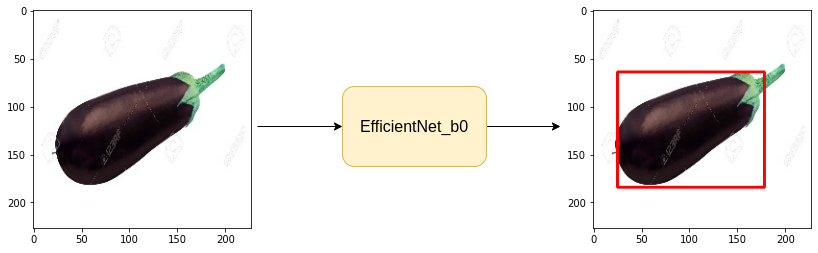

In [1]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [17]:
import sys
sys.path.append('object-localization-dataset')

# Configurations

In [25]:
CSV_FILE = 'object-localization-dataset/train.csv'
DATA_DIR = 'object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 1e-3
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [21]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

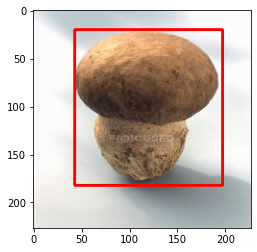

In [30]:
row = df.iloc[185]
image = cv2.imread(DATA_DIR + row.img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [31]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=123)

# Augmentations

In [32]:
import albumentations as A

In [47]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [56]:
class ObjLocDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, augmentation):
        self.df = df
        self.augmentation = augmentation
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        
        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax
        
        bboxes = [[xmin, ymin, xmax, ymax]]
        
        img_path = DATA_DIR + row.img_path
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentation:
            data = self.augmentation(image = image, bboxes = bboxes, class_labels = [None])
            image = data['image']
            bboxes = data['bboxes'][0]
        
        # (h, w, c) -> (c, h, w)
        image = torch.from_numpy(image).permute(2, 0, 1) / 255.
        bboxes = torch.Tensor(bboxes)
        
        return image, bboxes

In [53]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [54]:
print(f"Total example in train set : {len(trainset)}")
print(f"Total example in valid set : {len(validset)}")      

Total example in train set : 148
Total example in valid set : 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


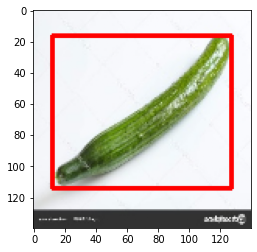

In [63]:
img, bbox = trainset[10]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [64]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

In [65]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [66]:
images, bboxes = next(iter(trainloader))

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [67]:
from torch import nn 
import timm

In [68]:
class ObjLocModel(nn.Module):
    
    def __init__(self):
        super(ObjLocModel, self).__init__()
        
        self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)
        
    def forward(self, images, gt_bboxes = None):
        bboxes = self.backbone(images)
        
        if gt_bboxes != None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
       
        return bboxes

In [70]:
model = ObjLocModel()
model.to(DEVICE)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

In [72]:
random_image = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_image).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [73]:
def train_model(model, dataloader, optimizer):
    total_loss = 0.0
    model.train()
    
    for data in tqdm(dataloader):
        
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
        
        bboxes, loss = model(images, gt_bboxes)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [74]:
def eval_model(model, dataloader):
    total_loss = 0.0
    model.eval()
    
    with torch.no_grad():
        for data in tqdm(dataloader):

            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)

            total_loss += loss.item()

        return total_loss / len(dataloader)

# Training Loop

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [77]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    
    train_loss = train_model(model, trainloader, optimizer)
    valid_loss = eval_model(model, validloader)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print('MODEL ARE SAVED')
        best_valid_loss = valid_loss
        
    print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 1 Train Loss : 1896.12490234375 Valid Loss : 3367.07666015625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 2 Train Loss : 1167.3742736816407 Valid Loss : 951.5177408854166


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 3 Train Loss : 750.8962188720703 Valid Loss : 206.661501566569


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 4 Train Loss : 510.4815307617188 Valid Loss : 136.7624766031901


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 358.6961975097656 Valid Loss : 153.29691569010416


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 293.21306762695315 Valid Loss : 172.42628479003906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 225.48200225830078 Valid Loss : 145.23055521647134


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 8 Train Loss : 185.46416778564452 Valid Loss : 131.80880228678384


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 9 Train Loss : 161.03569717407225 Valid Loss : 105.36275990804036


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 10 Train Loss : 144.57223892211914 Valid Loss : 88.41870625813802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 118.62023735046387 Valid Loss : 134.65032958984375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 12 Train Loss : 105.8548641204834 Valid Loss : 72.87335968017578


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 94.97630462646484 Valid Loss : 98.86642456054688


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 112.45637512207031 Valid Loss : 101.83315531412761


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 15 Train Loss : 88.51527404785156 Valid Loss : 67.85976537068684


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 79.51132011413574 Valid Loss : 82.03966267903645


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 17 Train Loss : 65.17601737976074 Valid Loss : 60.659356435139976


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 54.84372119903564 Valid Loss : 61.91856129964193


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 56.911695861816405 Valid Loss : 64.7776870727539


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 63.36071147918701 Valid Loss : 78.71918106079102


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 66.8916675567627 Valid Loss : 82.54737599690755


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 22 Train Loss : 71.23840675354003 Valid Loss : 52.177056630452476


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 23 Train Loss : 62.539717483520505 Valid Loss : 48.119711558024086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 61.50605030059815 Valid Loss : 80.94850413004558


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 57.49306221008301 Valid Loss : 57.438863118489586


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 26 Train Loss : 49.456482315063475 Valid Loss : 48.02398363749186


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 27 Train Loss : 43.98149471282959 Valid Loss : 45.8513437906901


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 Train Loss : 48.77528076171875 Valid Loss : 55.99083455403646


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 Train Loss : 47.99229965209961 Valid Loss : 79.19680086771648


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 30 Train Loss : 51.59080924987793 Valid Loss : 42.84200668334961


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 Train Loss : 50.4780309677124 Valid Loss : 46.34590403238932


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 Train Loss : 48.05607376098633 Valid Loss : 45.46599578857422


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 33 Train Loss : 40.31539459228516 Valid Loss : 38.262030283610024


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 Train Loss : 42.64461669921875 Valid Loss : 41.44319375356039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 Train Loss : 35.515166473388675 Valid Loss : 57.23556264241537


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 Train Loss : 37.40701026916504 Valid Loss : 45.079976399739586


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL ARE SAVED
Epoch : 37 Train Loss : 33.94514904022217 Valid Loss : 37.34455426534017


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 Train Loss : 45.202518463134766 Valid Loss : 47.71041488647461


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 Train Loss : 35.51973190307617 Valid Loss : 52.01408894856771


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 Train Loss : 32.5339111328125 Valid Loss : 42.223167419433594


# Inference

In [78]:
import cv2
import numpy
import torch 

import matplotlib.pyplot as plt 

def compare_plots(image, gt_bbox, out_bbox):

    xmin, ymin, xmax, ymax = gt_bbox

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]

    out_pt1 = (int(out_xmin), int(out_ymin))
    out_pt2 = (int(out_xmax), int(out_ymax))

    out_img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(),pt1, pt2,(0,255,0),2)
    out_img = cv2.rectangle(out_img,out_pt1, out_pt2,(255,0,0),2)
    plt.imshow(out_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


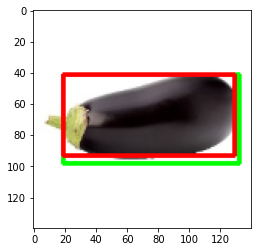

In [80]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    
    image, gt_bbox = validset[10]
    image = image.unsqueeze(0).to(DEVICE)
    out_bbox = model(image)
    
    compare_plots(image, gt_bbox, out_bbox)

try:
lr
epoch
img_size
model --> eff_b5 - eff_b7 - resnet50 - 
MSE metric -> IOU